In [32]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Fonction pour lire les données de transcription
def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Fonction pour lire les données du graphe de discours
def read_discourse_graph(file_path):
    with open(file_path, 'r') as file:
        data = [line.strip().split() for line in file]

    # Convertir les valeurs non numériques en indices numériques
    data = [(int(start), relation, int(end)) if start.isdigit() and end.isdigit() else (start, relation, end) for start, relation, end in data]

    return data

def create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict):
    rows = []

      # Iterate through all edges in the discourse graph
    for edge in discourse_graph:
        index_start, relation_type, index_end = edge

        # Retrieve speaker information
        speaker = transcription[index_start]['speaker']

        # Convert relation type to integer using the dictionary
        speaker_id = speaker_dict.get(speaker, -1)

        # Retrieve the sentence
        text = transcription[index_start]['text']

        # Convert relation type to integer using the dictionary
        relation_type_id = relation_dict.get(relation_type, -1)

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index_start': index_start,
            'text': text,
            'index_end': index_end,
            'speaker_type': speaker_id,
            'speaker_text': speaker,
            'relation_type': relation_type_id,
            'relation_text': relation_type
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df


# Fonction pour créer le dictionnaire de conversion des relations
def create_relation_dict(discourse_graph):
    relation_set = set()

    # Collecter toutes les relations uniques
    for edge in discourse_graph:
        relation_set.add(edge[1])

    # Créer un dictionnaire de conversion
    relation_dict = {relation: idx for idx, relation in enumerate(relation_set)}

    return relation_dict

# Fonction pour créer le dictionnaire de conversion des speakers
def create_speaker_dict(transcription):
    speaker_set = set()

    # Collecter tous les locuteurs uniques
    for utterance in transcription:
        speaker_set.add(utterance['speaker'])

    # Créer un dictionnaire de conversion
    speaker_dict = {speaker: idx for idx, speaker in enumerate(speaker_set)}

    return speaker_dict

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]

In [34]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
dialogue_ids = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
dialogue_ids = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids])
dialogue_ids.remove('IS1002a')
dialogue_ids.remove('IS1005d')
dialogue_ids.remove('TS3012c')

dialogue_ids_test = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
dialogue_ids_test = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids_test])

# Liste pour stocker les DataFrames de chaque dialogue
dfs = []
dfs_test = []

In [35]:
# Parcourir chaque dialogue
for dialogue_id in dialogue_ids:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_train / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_train / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs.append(df)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs.append(pd.DataFrame([last_row]))

# Parcourir chaque dialogue
for dialogue_id in dialogue_ids_test:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_test / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_test / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df_test = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs_test.append(df_test)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs_test.append(pd.DataFrame([last_row]))

In [36]:
# Concaténer tous les DataFrames en un seul
df = pd.concat(dfs, ignore_index=True)
df_test = pd.concat(dfs_test, ignore_index=True)

with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index_start'], labels_data), axis=1)

In [37]:
df['bert'] = df['text']
for transcription_id in dialogue_ids:
    bert_array = np.load('feature_bert/training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'bert'] = value

df_test['bert'] = df_test['text']
for transcription_id in dialogue_ids_test:
    bert_array_test = np.load('feature_bert/test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'bert'] = value


In [38]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['bert'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)


# Nombre d'éléments dans chaque liste
num_elements = len(df_test['bert'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)


In [46]:
# Compter le nombre d'occurrences de chaque dialogue_id_index_start
comment_counts = df.groupby(['dialogue_id', 'index_start']).size().reset_index(name='occurrence')

# Ajouter la colonne 'label' au DataFrame
comment_counts['label'] = df.groupby(['dialogue_id', 'index_start'])['label'].first().values

# Afficher le nouveau DataFrame
print(comment_counts)

      dialogue_id  index_start  occurrence  label
0         ES2002a            0           1      0
1         ES2002a            1           1      0
2         ES2002a            2           1      1
3         ES2002a            3           1      0
4         ES2002a            4           1      0
...           ...          ...         ...    ...
53386     TS3012d         1277           1      0
53387     TS3012d         1278           1      0
53388     TS3012d         1279           2      0
53389     TS3012d         1281           1      0
53390     TS3012d         1282           1      0

[53391 rows x 4 columns]


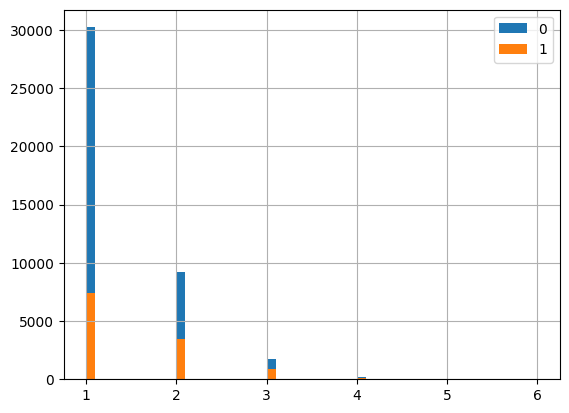

In [52]:
comment_counts[comment_counts['label'] == 0]['occurrence'].hist(bins=50, label='0')
comment_counts[comment_counts['label'] == 1]['occurrence'].hist(bins=50, label='1')
plt.legend()
plt.show()